## Binarization Algorithm

#### This is an image binarization algorithm that uses the Otsu's method to find the optimal threshold value for the binarization of the image.
---

In [50]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from skimage.metrics import structural_similarity as ssim_sm

# Change the path to the image you want to binarize and the path to the output image
input_path = "../Images/binarization/5img.jpeg"
output_path = "../Images/binarization/5img_bin.jpeg"

#### Functions definition

In [51]:
# Loss function
def get_loss(num, bin, thresh, tuning_method, under_tuning, over_tuning):
    bin = bin[:-1]

    # distance if the pixel is under the threshold
    dist_under_thresh = bin[:thresh]
    # distance if the pixel is over the threshold
    dist_over_thresh = 255 - bin[thresh:]

    # Tune according to 'skewness' and value inserted by the user
    if tuning_method == "Auto":
        weighted = bin * num
        m = np.sum(weighted) / np.sum(num)
        tuning = np.abs(m - 128)

        if m > (256 / 2):
            tuned_dist_under_thresh = dist_under_thresh
            tuned_dist_over_thresh = dist_over_thresh + tuning
        elif m < (256 / 2):
            tuned_dist_under_thresh = dist_under_thresh + tuning
            tuned_dist_over_thresh = dist_over_thresh
        else:
            tuned_dist_under_thresh = dist_under_thresh
            tuned_dist_over_thresh = dist_over_thresh

    else:
        tuned_dist_under_thresh = dist_under_thresh + under_tuning
        tuned_dist_over_thresh = dist_over_thresh + over_tuning

    # concatenate the two parts
    dist_mat = np.concatenate((tuned_dist_under_thresh, tuned_dist_over_thresh))
    loss = np.sum(num * dist_mat)  # Loss function
    return loss


def get_best_thresh(
    num, bin, tuning_method="Auto", under_tuning=None, over_tuning=None, show_loss=False
):
    loss_list = []

    if tuning_method == "Manual":
        if under_tuning is None or over_tuning is None:
            print("Please insert values for tuning")
            return
    else:
        weighted = bin[:-1] * num
        m = np.sum(weighted) / np.sum(num)
        if m > (256 / 2 + 10):
            under_over = "over"
        else:
            under_over = "under"
        print(f"Tuning parameter (128 - mean): {np.abs(m - 128)} --> {under_over}")

    for i in range(1, 255):
        loss = get_loss(num, bin, i, tuning_method, under_tuning, over_tuning)
        loss_list.append(loss)
    min_loss = np.min(loss_list)
    best_thresh = np.argmin(loss_list)
    if show_loss:
        plt.figure()
        plt.plot(loss_list)
        plt.title("Loss function")

    return best_thresh, min_loss, loss_list


def apply_thresh(img_gray, thresh, show_img=False):
    img_bin = img_gray > thresh  # Mask
    if show_img:
        plt.figure()
        plt.imshow(img_bin, cmap="gray")
        plt.title("Binarized"), plt.xticks([]), plt.yticks([])
    return img_bin

#### Main program

The best threshold is:  132
The minimum loss is:  89865698.0


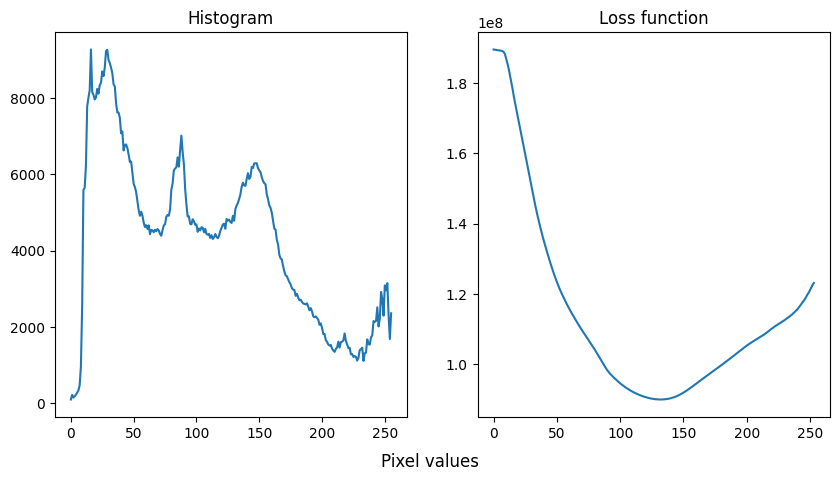

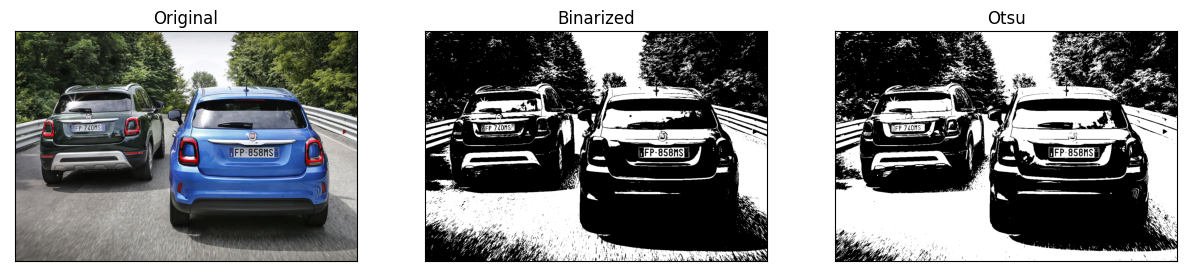

In [52]:
# Load image
img = cv.imread(input_path, cv.IMREAD_COLOR)

# Convert to grayscale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Compute the histogram
num, bin = np.histogram(img_gray.ravel(), 256, [0, 256])

# Get and apply the best threshold
best_thresh, min_loss, losses = get_best_thresh(
    num, bin, tuning_method="Manual", over_tuning=20, under_tuning=10, show_loss=False
)
img_bin = apply_thresh(img_gray, best_thresh, show_img=False)

print("The best threshold is: ", best_thresh)
print("The minimum loss is: ", min_loss)

# Binarization with Otsu's method
img_otsu = cv.threshold(img_gray, 0, 255, cv.THRESH_OTSU)[1]

# Show the results
# Histogram and Loss
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Histogram")
axs[0].plot(num)
axs[1].set_title("Loss function")
axs[1].plot(losses)
fig.text(0.5, 0.01, "Pixel values", ha="center", fontsize=12)

# Images comparison
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Plot the original image in the first subplot
axs[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axs[0].set_title("Original")
axs[0].set_xticks([]), axs[0].set_yticks([])

# Plot the binarized image in the second subplot
axs[1].imshow(img_bin, cmap="gray")
axs[1].set_title("Binarized")
axs[1].set_xticks([]), axs[1].set_yticks([])

# Plot the Otsu image in the third subplot
axs[2].imshow(img_otsu, cmap="gray")
axs[2].set_title("Otsu")
axs[2].set_xticks([]), axs[2].set_yticks([])

# Show the plots
plt.show()

#### Store the image in the output_path

In [53]:
# Save the binarized image
# Check if the file already exists
if os.path.exists(output_path):
    print(
        f"Warning: The file {output_path} already exists. Skipping save operation."
    )
else:
    # Convert it to 0 and 255
    img_bin = (img_bin * 255).astype(np.uint8)

    # Save the binary image as a JPEG file
    cv.imwrite(output_path, img_bin)

### SSIM between Otsu's method and the binarization algorithm
---

Tuning parameter (128 - mean): 26.861286122578605 --> over
Tuning parameter (128 - mean): 11.394702911376953 --> under
Tuning parameter (128 - mean): 114.67148648648649 --> over
Tuning parameter (128 - mean): 39.89164161656646 --> under
Tuning parameter (128 - mean): 20.162826538085938 --> under
Tuning parameter (128 - mean): 7.100090026855469 --> under


/tmp/ipykernel_1227/1792340815.py:25: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  ssim = ssim_sm(img_bin, img_otsu)


Tuning parameter (128 - mean): 11.232597623089987 --> over
Tuning parameter (128 - mean): 3.9514389038085938 --> under
Tuning parameter (128 - mean): 22.01344385901163 --> under
Tuning parameter (128 - mean): 12.386144807875525 --> over
Tuning parameter (128 - mean): 5.909126281738281 --> under
Tuning parameter (128 - mean): 3.94305419921875 --> under
Tuning parameter (128 - mean): 13.867733001708984 --> under
Tuning parameter (128 - mean): 29.34570648677783 --> under
Tuning parameter (128 - mean): 3.6294479370117188 --> under
Tuning parameter (128 - mean): 22.01344385901163 --> under
Tuning parameter (128 - mean): 57.75028144278832 --> over
Tuning parameter (128 - mean): 8.543632507324219 --> under
Tuning parameter (128 - mean): 59.33258749999999 --> over
Tuning parameter (128 - mean): 78.80022727272728 --> over
Tuning parameter (128 - mean): 11.092575073242188 --> under
Tuning parameter (128 - mean): 114.19380533818288 --> under
Tuning parameter (128 - mean): 44.727121365285115 --> o

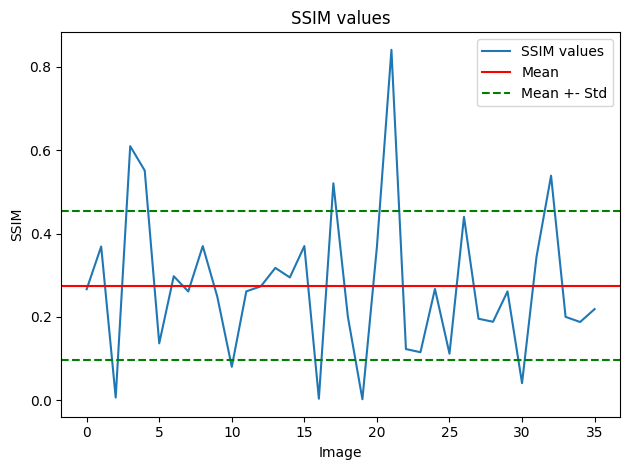

In [54]:
filenames = os.listdir("../Images/binarization")
#filenames.remove(".DS_Store")
filenames.remove("tested")
ssim_list = []

for file in filenames:
     
	# Load image
	img = cv.imread('../Images/binarization/'+file, cv.IMREAD_COLOR)

	# Convert to grayscale
	img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

	# Compute the histogram
	num, bin = np.histogram(img_gray.ravel(), 256, [0, 256])
 
	# Get and apply the best threshold
	best_thresh, min_loss, losses = get_best_thresh(num, bin, tuning_method = 'Auto', show_loss=False)
	img_bin = apply_thresh(img_gray, best_thresh, show_img = False)

	# Binarization with Otsu's method
	img_otsu = cv.threshold(img_gray, 0, 255, cv.THRESH_OTSU)[1]

	# Compute SSIM between the binarized images
	ssim = ssim_sm(img_bin, img_otsu)
	ssim_list.append(ssim)

mean_ssim = np.mean(ssim_list)
std_ssim = np.std(ssim_list)

# Plot the SSIM values togeter with the mean and the standard deviation lines
plt.figure()
plt.plot(ssim_list)
plt.axhline(y = mean_ssim, color = 'r', linestyle = '-')
plt.axhline(y = mean_ssim + std_ssim, color = 'g', linestyle = '--')
plt.axhline(y = mean_ssim - std_ssim, color = 'g', linestyle = '--')
plt.title('SSIM values')
plt.xlabel('Image')
plt.ylabel('SSIM')
plt.legend(['SSIM values', 'Mean', 'Mean +- Std'], loc = 'upper right')
plt.tight_layout()
plt.show()